## TUTORIAL 01 - Thermal block problem
**_Keywords: certified reduced basis method, scalar problem_**

### 1. Introduction
In this Tutorial, we consider steady heat conduction in a two-dimensional domain $\Omega$.

We define two subdomains $\Omega_1$ and $\Omega_2$, such that
1. $\Omega_1$ is a disk centered at the origin of radius $r_0=0.5$, and
2. $\Omega_2=\Omega/\ \overline{\Omega_1}$. 

The conductivity $\kappa$ is assumed to be constant on $\Omega_1$ and $\Omega_2$, i.e.
$$
\kappa|_{\Omega_1}=\kappa_0 \quad \textrm{and} \quad \kappa|_{\Omega_2}=1.
$$

For this problem, we consider $P=2$ parameters:
1. the first one is related to the conductivity in $\Omega_1$, i.e. $\mu_0\equiv k_0$ (_note that parameters numbering is zero-based_);
2. the second parameter $\mu_1$ takes into account the constant heat flux over $\Gamma_{base}$.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.1,10]\times[-1,1].
$$

In this problem we model the heat transfer process due to the heat flux over the bottom boundary $\Gamma_{base}$ and the following conditions on the remaining boundaries:
* the left and right boundaries $\Gamma_{side}$ are insulated,
* the top boundary $\Gamma_{top}$ is kept at a reference temperature (say, zero),

with the aim of measuring the average temperature on $\Gamma_{base}$.

In order to obtain a faster evaluation (yet, provably accurate) of the output of interest we propose to use a certified reduced basis approximation for the problem.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the temperature in the domain $\Omega$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$
\begin{cases}
	- \text{div} (\kappa(\mu_0)\nabla u(\boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
	u(\boldsymbol{\mu}) = 0 & \text{on } \Gamma_{top},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = 0 & \text{on } \Gamma_{side},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = \mu_1 & \text{on } \Gamma_{base}.
\end{cases}
$$
<br>

where 
* $\mathbf{n}$ denotes the outer normal to the boundaries $\Gamma_{side}$ and $\Gamma_{base}$,
* the conductivity $\kappa(\mu_0)$ is defined as follows:
$$
\kappa(\mu_0) =
\begin{cases}
	\mu_0 & \text{in } \Omega_1,\\
	1 & \text{in } \Omega_2,\\
\end{cases}
$$

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H^1(\Omega) : v|_{\Gamma_{top}}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \kappa(\mu_0)\nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \mu_1\int_{\Gamma_{base}}v \ ds.$$

The (compliant) output of interest $s(\boldsymbol{\mu})$ given by
$$s(\boldsymbol{\mu}) = \mu_1\int_{\Gamma_{base}} u(\boldsymbol{\mu})$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega_1}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega_2}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_1(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{\mu_1}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{base}}v \ ds}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class ThermalBlock(EllipticCoerciveCompliantProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
class ThermalBlock(EllipticCoerciveCompliantProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveCompliantProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)

    # Return custom problem name
    def name(self):
        return "ThermalBlock"

    # Return the alpha_lower bound.
    def get_stability_factor_lower_bound(self):
        return min(self.compute_theta("a"))

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = 1.
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = mu[1]
            return (theta_f0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx(1)
            a1 = inner(grad(u), grad(v)) * dx(2)
            return (a0, a1)
        elif term == "f":
            ds = self.ds
            f0 = v * ds(1)
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/thermal_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/thermal_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/thermal_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the ThermalBlock class

In [5]:
problem = ThermalBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = PODGalerkin(problem)#ReducedBasis(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(1e-10)#1e-5)

### 4.5. Perform the offline phase

In [7]:
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

### 4.5b Train the neural network

In [8]:
reduction_method.initialize_testing_set(100)
test_mu = torch.tensor(reduction_method.testing_set)

In [9]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN(problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, optimizer, 
    suffix=pinn_loss.name(), by_validation=True
)

In [10]:
Training.normalize_and_train_pinn(
    pinn_net, data, pinn_loss, optimizer,
    input_normalization_pinn, epochs=10000, starting_epoch=starting_epoch
)

0 1.7709647554883872 	Loss(validation) = 1.502154839342027
100 0.6771369346194789 	Loss(validation) = 0.6369518005124916
200 0.06286035535428149 	Loss(validation) = 0.07098408564114751
300 0.037320138412315226 	Loss(validation) = 0.04865965281652305
400 0.025022301764197497 	Loss(validation) = 0.03514211258966928
500 0.01847264061816743 	Loss(validation) = 0.027784727786740092
600 0.01365450921266705 	Loss(validation) = 0.022321343210772875
700 0.010077664227215838 	Loss(validation) = 0.01787323648479532
800 0.007545894868144834 	Loss(validation) = 0.014392023991883069
900 0.005788722421386207 	Loss(validation) = 0.011730220145994594
1000 0.004563104749665397 	Loss(validation) = 0.009698988070153089
1100 0.0036805132680291187 	Loss(validation) = 0.008136806127829327
1200 0.003056461432086978 	Loss(validation) = 0.006947266102388733
1300 0.0025447696479523256 	Loss(validation) = 0.006042314349701559
1400 0.0021614099570760243 	Loss(validation) = 0.005327762947147844
1500 0.0018640683705

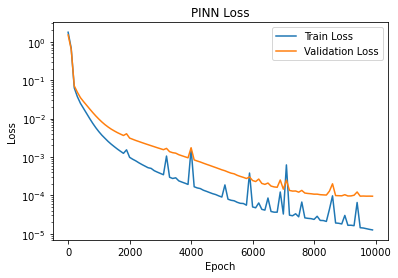

In [11]:
fig, ax = Training.plot_loss(pinn_net)

In [12]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn
)

#################################### N = 4 #####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.00018018947299983958	0.0001801911476972098	3.548215432614033e-07
mean	0.009128474416621474	0.009128476768022495	5.070341389591286e-07
max	0.3980618671439147	0.39806188288956934	1.792591605054079e-06


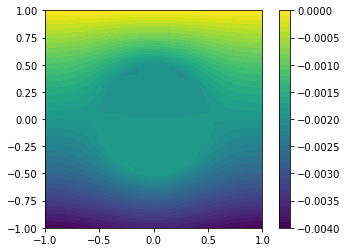

In [13]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, (8.0, -1.0), input_normalization_pinn, output_normalization_pinn
)

In [14]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN(problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, optimizer, 
    suffix=pdnn_loss.name(), by_validation=True
)

In [15]:
Training.normalize_and_train_pdnn(
    pdnn_net, data, pdnn_loss, optimizer,
    input_normalization_pdnn, epochs=10000, starting_epoch=starting_epoch
)

0 0.9954960715594445 	Loss(validation) = 1.2549901620453445
100 0.11801497059146551 	Loss(validation) = 0.13749405144005014
200 0.026200391100130373 	Loss(validation) = 0.02199461749626771
300 0.009793393676366528 	Loss(validation) = 0.008528400061681334
400 0.005879293982661514 	Loss(validation) = 0.0066561782289561834
500 0.0037267267785916222 	Loss(validation) = 0.0047423252849900155
600 0.002355128350346999 	Loss(validation) = 0.0031290482847434104
700 0.0014849399864980404 	Loss(validation) = 0.0019627259877376827
800 0.0009626446077429775 	Loss(validation) = 0.0012658916312420316
900 0.000670275794612188 	Loss(validation) = 0.0009200350004151394
1000 0.000511797744639006 	Loss(validation) = 0.0007673528786771711
1100 0.00042128288846661054 	Loss(validation) = 0.0006974837686046098
1200 0.0003640395093148231 	Loss(validation) = 0.0006592339015278496
1300 0.00032431472563793377 	Loss(validation) = 0.0006347718878603151
1400 0.0002989405437712277 	Loss(validation) = 0.00061397970710

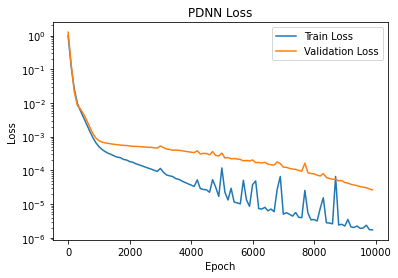

In [16]:
fig, ax = Training.plot_loss(pdnn_net)

In [17]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)

#################################### N = 4 #####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.00018068645520686254	0.0001806868809128583	3.548215432614033e-07
mean	0.0042121788522789996	0.004212177916428704	5.070341389591286e-07
max	0.165828470586436	0.16582848426929236	1.792591605054079e-06


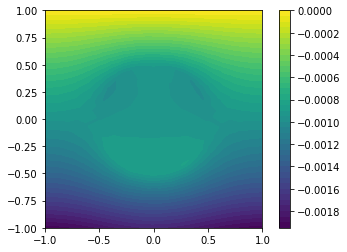

In [18]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, (8.0, -1.0), input_normalization_pdnn, output_normalization_pdnn
)

In [19]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

prnn_net  = NN.RONN(problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=1.)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, optimizer, 
    suffix=prnn_loss.name(), by_validation=True
)

In [20]:
Training.normalize_and_train_prnn(
    prnn_net, data, prnn_loss, optimizer,
    input_normalization_prnn, epochs=10000, starting_epoch=starting_epoch
)

0 3.710692292262873 	Loss(validation) = 3.0391787631512783
100 1.20429524699261 	Loss(validation) = 1.0574338241510954
200 0.11885920090045163 	Loss(validation) = 0.09612088102521715
300 0.08934203493534998 	Loss(validation) = 0.07131639214387367
400 0.057164943826779654 	Loss(validation) = 0.0437743019584906
500 0.03671519738748899 	Loss(validation) = 0.02559143324399554
600 0.026250546813423765 	Loss(validation) = 0.016285196608637927
700 0.01997371990949845 	Loss(validation) = 0.010753131409060143
800 0.015560704814438359 	Loss(validation) = 0.007143508303712359
900 0.012273641002123813 	Loss(validation) = 0.0048991296468469
1000 0.009742584554386364 	Loss(validation) = 0.003591715071494182
1100 0.007741901035318249 	Loss(validation) = 0.002885303930447074
1200 0.006141643460933615 	Loss(validation) = 0.002540836334811721
1300 0.004865512968613956 	Loss(validation) = 0.0023942395284921292
1400 0.003858752918126217 	Loss(validation) = 0.0023342990145829474
1500 0.003073828284763414 	

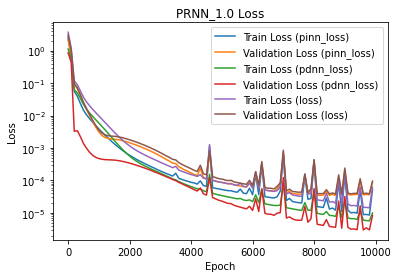

In [21]:
fig, ax = Training.plot_loss(prnn_net, separate=True)

In [22]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn
)

#################################### N = 4 #####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0016979670513752535	0.0016979600251266918	3.548215432614033e-07
mean	0.023502969380878244	0.023502968952038152	5.070341389591286e-07
max	1.3434333971349304	1.3434334261777745	1.792591605054079e-06


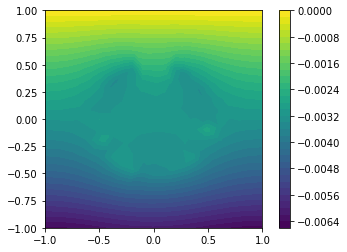

In [23]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, (8.0, -1.0), input_normalization_prnn, output_normalization_prnn
)

In [24]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_mu, input_normalizations, output_normalizations, euclidean=False
)

#####################################################################################
Mean Relative Error for 4 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	0.009128474416621474	0.009128476768022495	5.070341389591286e-07
pdnn_net	0.0042121788522789996	0.004212177916428704	5.070341389591286e-07
prnn_net	0.023502969380878244	0.023502968952038152	5.070341389591286e-07
#####################################################################################


### 4.7. Perform an error analysis

In [25]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()

=               ThermalBlock POD-Galerkin error analysis begins                =

###################################### 0 #######################################
###################################### 1 #######################################
###################################### 2 #######################################
###################################### 3 #######################################
###################################### 4 #######################################
###################################### 5 #######################################
###################################### 6 #######################################
###################################### 7 #######################################
###################################### 8 #######################################
###################################### 9 #######################################
###################################### 10 ######################################
###########################

###################################### 98 ######################################
###################################### 99 ######################################

N	gmean(error_u)        	max(error_u)          	gmean(relative_error_u)	max(relative_error_u) 
1	0.11275177641762783   	0.8195182539018759    	0.16486776801403993    	0.5446031989422366    
2	0.0009016781236488201 	0.012015686746355421  	0.001318450710367942   	0.008056270650019638  
3	1.3261126471717294e-05	0.00016659535987189713	1.9390668530541393e-05 	0.00011169875983763633
4	2.1973705618927806e-07	7.141903706394859e-06 	3.213036561811362e-07  	4.788499436584216e-06 

N	gmean(error_output)   	max(error_output)     	gmean(relative_error_output)	max(relative_error_output)
1	0.012712963085365207  	0.6716101684783986    	0.027181380930005106        	0.2965926442981213        
2	8.130234804979419e-07 	0.0001443767279978303 	1.738312365108095e-06       	6.490349679144264e-05     
3	1.7586621413639273e-10	2.7754025744286537e-08	3

### 4.8. Perform a speedup analysis

In [26]:
reduction_method.initialize_testing_set(100)
reduction_method.speedup_analysis()

=              ThermalBlock POD-Galerkin speedup analysis begins               =

###################################### 0 #######################################
###################################### 1 #######################################
###################################### 2 #######################################
###################################### 3 #######################################
###################################### 4 #######################################
###################################### 5 #######################################
###################################### 6 #######################################
###################################### 7 #######################################
###################################### 8 #######################################
###################################### 9 #######################################
###################################### 10 ######################################
###########################

###################################### 99 ######################################

N	min(speedup_solve)	gmean(speedup_solve)	max(speedup_solve)
1	3.0058386855045875	5.869489935858786   	31.955088755337762
2	1.9981483300867418	7.465686121078874   	42.604440303281955
3	3.768177927725565 	7.559547875017129   	30.62788594934462 
4	1.5060014182866623	7.297860744124146   	21.025152528203073

N	min(speedup_output)	gmean(speedup_output)	max(speedup_output)
1	2.197797738609021  	4.761324872790398    	24.965850907988113 
2	1.8595433170922624 	5.766549062698305    	30.871157115423006 
3	3.242692119989073  	5.893816963101725    	24.286235693128628 
4	1.1566004023863392 	5.6070318981746325   	15.59569002032659  

=               ThermalBlock POD-Galerkin speedup analysis ends                =

